In [1]:
# The code was removed by DSX for sharing.

In [3]:
df = sqlContext.read.format('com.databricks.spark.csv').options(inferschema='true',codec="org.apache.hadoop.io.compress.GzipCodec").load(path_1)

In [5]:
df.show()

+------------------+----------+-------+----------+---------+--------------------+----------+------------------+------------------+
|               _c0|       _c1|    _c2|       _c3|      _c4|                 _c5|       _c6|               _c7|               _c8|
+------------------+----------+-------+----------+---------+--------------------+----------+------------------+------------------+
|616018411009744896|1435723208|   83.0|-73.951206| 40.79435|Incident on #Vari...|  52272942|      511NY-Tweets|      511NY-Tweets|
|616018411601174528|1435723209|   83.0|-73.951206| 40.79435|Incident on #Vari...|  50706690|      511NY-Tweets|      511NY-Tweets|
|616018439988203521|1435723215|10022.0|-73.975925|40.759936|I'm at Fifth Aven...|  47776080|        Foursquare|        Foursquare|
|616018485001461761|1435723226|10002.0|-73.988408|40.716612|Doughnut Plant @ ...|2236311853|         Instagram|         Instagram|
|616018508665749504|1435723232|10464.0|-73.789597|40.851002|i done came throu...|  

In [8]:
oldColumns = df.schema.names
newColumns = ["id", "timestamp", "zipcode", "lon", "lat", "tweets", "user_id", "application", "source"]

df_2 = reduce(lambda df, idx: df.withColumnRenamed(oldColumns[idx], newColumns[idx]), xrange(len(oldColumns)), df)
df_2.printSchema()

root
 |-- id: string (nullable = true)
 |-- timestamp: string (nullable = true)
 |-- zipcode: string (nullable = true)
 |-- lon: string (nullable = true)
 |-- lat: string (nullable = true)
 |-- tweets: string (nullable = true)
 |-- user_id: string (nullable = true)
 |-- application: string (nullable = true)
 |-- source: string (nullable = true)



In [16]:
from pyspark.sql.types import IntegerType, TimestampType, FloatType

df_2 = df_2.withColumn("id", df_2["id"].cast(IntegerType()))
df_2 = df_2.withColumn("timestamp", df_2["timestamp"].cast(TimestampType()))
df_2 = df_2.withColumn("lon", df_2["lon"].cast(FloatType()))
df_2 = df_2.withColumn("lat", df_2["lat"].cast(FloatType()))

In [17]:
sqlContext.registerDataFrameAsTable(df_2, "tw_crime")

In [102]:
from pyspark.sql.functions import hour, mean, count, date_format, month, weekofyear

In [31]:
from pyspark.sql.functions import hour, mean, count, date_format, month, weekofyear

(df_2.dropDuplicates(['id'])
    .groupBy([hour("timestamp").alias("hour"), month("timestamp").alias("month")])
    .agg(count("id").alias("count"))
    .show())

+----+-----+-----+
|hour|month|count|
+----+-----+-----+
|  23|    6| 1777|
|  10|    2|   54|
|  17|    1|  495|
|  16|    3| 5383|
|  17|    2|  379|
|  13|   10|  328|
|   4|   10|  118|
|   9|   10|   71|
|   6|    1|   92|
|   3|    1|  737|
|  17|    3| 5439|
|   7|    4|  258|
|  22|    8|  571|
|   2|    2|  470|
|  22|    9|  654|
|  18|    1|  537|
|  22|    6| 1104|
|   8|    9|  135|
|   9|    4|   98|
|  19|    2|  429|
+----+-----+-----+
only showing top 20 rows



In [20]:
import pandas as pd

In [25]:
#gre_histogram = df_2.groupBy(hour("timestamp").alias("hour")).agg(count("id").alias("count")).topandas()

In [103]:
a = df_2.dropDuplicates(['id'])\
    .groupBy([hour("timestamp").alias("hour"), month("timestamp").alias("month")])\
    .agg(count("id").alias("count"))\
    .toPandas()

KeyboardInterrupt: 

In [39]:
import seaborn as sns
sns.set()
%matplotlib inline

In [41]:
a = a.dropna(subset=['hour','month']).fillna(0)
a.hour = a.hour.apply(int).apply(str)
a.month = a.month.apply(int).apply(str)

TypeError: ufunc 'isnan' not supported for the input types, and the inputs could not be safely coerced to any supported types according to the casting rule ''safe''

In [43]:
a.isnull().sum()

hour     0
month    0
count    0
dtype: int64

In [56]:
kk = a.groupby(['hour','month'])['count'].sum().unstack()

In [63]:
[str(i) for i in range(1,13) if i!=7]

['1', '2', '3', '4', '5', '6', '8', '9', '10', '11', '12']

In [64]:
kk = kk.reindex([str(i) for i in range(0,24)])
kk = kk[[str(i) for i in range(1,13) if i!=7]]

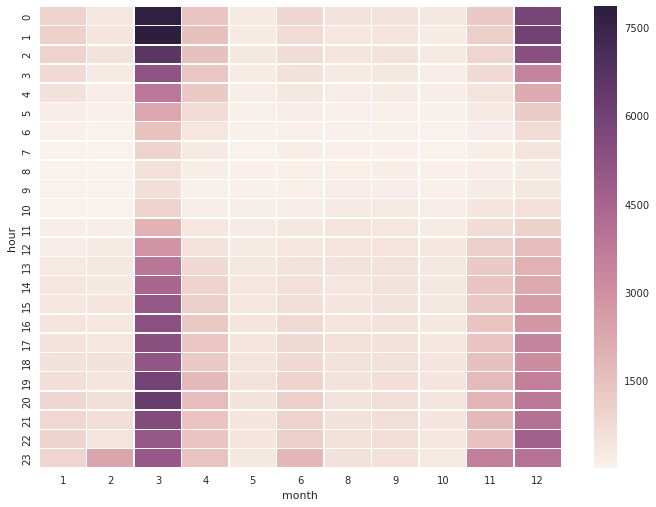

In [72]:
import  matplotlib.pyplot as plt
fig, ax = plt.subplots()
# the size of A4 paper
fig.set_size_inches(11.7, 8.27)
ax = sns.heatmap(kk, linewidths=.5,)

In [75]:
b = df_2.dropDuplicates(['id'])\
    .groupBy([hour("timestamp").alias("hour"), day("timestamp").alias("day")])\
    .agg(count("id").alias("count"))\
    .toPandas()

In [79]:
b = b.dropna()

In [87]:
b.week = b.week.apply(lambda x:str(x%4))

In [88]:
kk_w = b.groupby(['hour','week'])['count'].sum().unstack()

In [89]:
kk_w.columns.values

array(['0', '1', '2', '3'], dtype=object)

In [90]:
kk_w = kk_w.reindex([str(i) for i in range(0,24)])
kk_w = kk_w[[str(i) for i in range(0,4) if i!=7]]

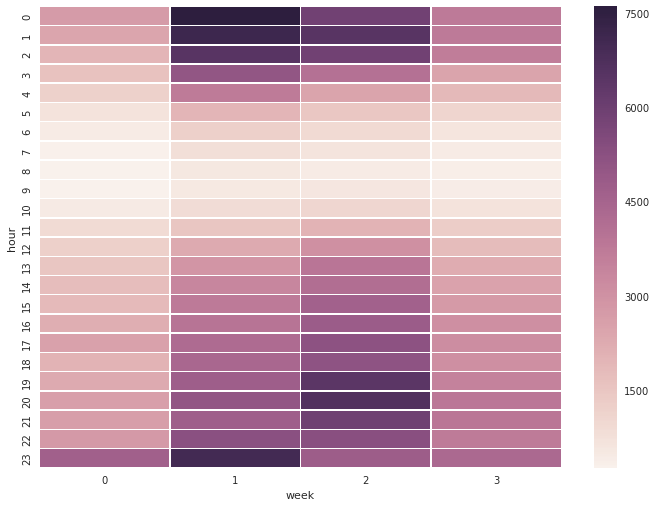

In [92]:
import  matplotlib.pyplot as plt
fig, ax = plt.subplots()
# the size of A4 paper
fig.set_size_inches(11.7, 8.27)
ax = sns.heatmap(kk_w, linewidths=.5,)

In [112]:
tcp_interactions = sqlContext.sql("""SELECT count(*), hour(timestamp), date_format(timestamp,'EEEE') from tw_crime GROUP BY hour(timestamp), date_format(timestamp,'EEEE')""")

In [114]:
result = tcp_interactions.toPandas()

In [115]:
result.head()

,count(1),hour(timestamp),"date_format(timestamp, EEEE)"
0,43584,4.0,Wednesday
1,13338,9.0,Saturday
2,13494,8.0,Thursday
3,15689,7.0,Thursday
4,60528,3.0,Monday


In [116]:
result = result.groupby(['hour(timestamp)', 'date_format(timestamp, EEEE)'])['count(1)'].sum().unstack()

In [119]:
result = result[["Monday","Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]]

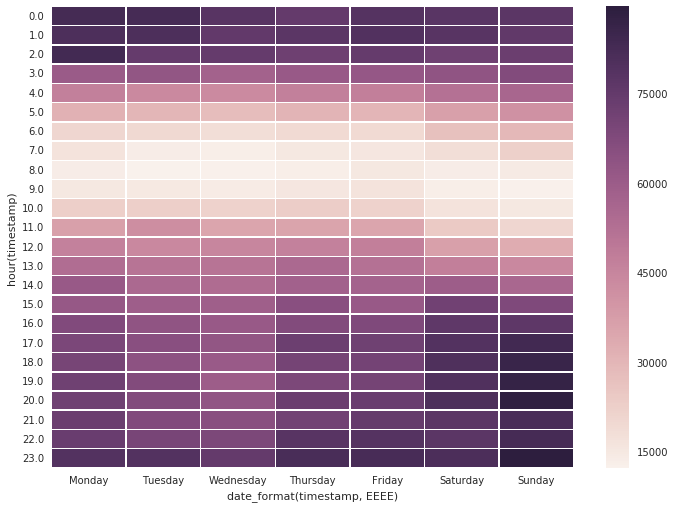

In [120]:
import  matplotlib.pyplot as plt
fig, ax = plt.subplots()
# the size of A4 paper
fig.set_size_inches(11.7, 8.27)
ax = sns.heatmap(result, linewidths=.5,)